### Вариант 4  
1. Разработать простую CNN с функцией активации ReLU с одним свёрточным слоем для сегментации клеток. 
2. Реализовать аугментацию данных (сдвиг) для улучшения сегментации. 
3. Использовать небольшой датасет, содержащий изображения клеток и соответствующие маски для сегментации. 
4. Обучить модель на этом датасете. 
5. Оценить качество сегментации с помощью метрик Dice и IoU. 
6. Визуализировать результаты на нескольких тестовых изображениях. 

In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Sequential 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization
import tensorflow.keras.backend as K

In [3]:
def images_loader(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, (128, 128))
            img = img / 255.0
            images.append(img)
    return np.array(images).reshape(-1, 128, 128, 1)

In [4]:
train_images = images_loader('data/train/original')
train_masks = images_loader('data/train/mask')
test_images = images_loader('data/test/original')
test_masks = images_loader('data/test/mask')

Аугментация данных только для тренировочного набора

In [7]:
train_datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1)
train_generator = train_datagen.flow(train_images, train_masks, batch_size=16)

# test_datagen = ImageDataGenerator()
# test_generator = test_datagen.flow(test_images, test_masks, batch_size=16)

Пример модели №1

In [8]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(128, 128, 1)),
    MaxPooling2D((2, 2)),
    UpSampling2D((2, 2)),
    Conv2D(1, (3, 3), activation='sigmoid', padding='same'),
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [9]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(train_generator, epochs=20, validation_data=(test_images, test_masks), callbacks=early_stop)

Epoch 1/20


c:\Users\kachu\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - accuracy: 0.6984 - loss: 0.6244 - val_accuracy: 0.6821 - val_loss: 0.5481
Epoch 2/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - accuracy: 0.7046 - loss: 0.5913 - val_accuracy: 0.6821 - val_loss: 0.5343
Epoch 3/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - accuracy: 0.7021 - loss: 0.5886 - val_accuracy: 0.6845 - val_loss: 0.5163
Epoch 4/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - accuracy: 0.7059 - loss: 0.5837 - val_accuracy: 0.6996 - val_loss: 0.5042
Epoch 5/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - accuracy: 0.6990 - loss: 0.5869 - val_accuracy: 0.6972 - val_loss: 0.4947
Epoch 6/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - accuracy: 0.7000 - loss: 0.5842 - val_accuracy: 0.7002 - val_loss: 0.4889
Epoch 7/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - accuracy: 0.6987 - loss: 0.5830 - val_accuracy: 0.7134 - val_loss: 0.4885
Epoch 8/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - accuracy: 0.7061 - loss: 0.5749 - val_accuracy: 0.7282 - val_loss: 0.

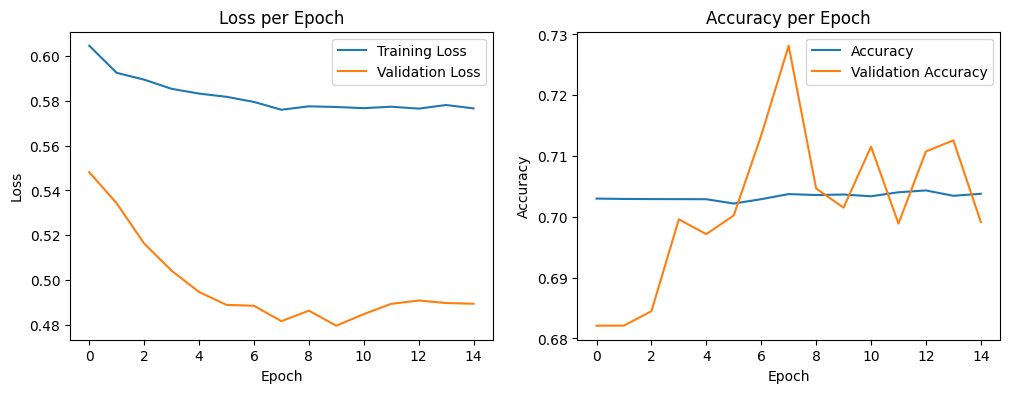

In [10]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch')
plt.legend()

plt.show()

In [11]:
pred_masks = model.predict(test_images)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Вычисление метрик DICE и IoU

###### DICE = TP / (TP+FP+FN)   or   DICE = 2|A in B| / |A| + |B|

###### IoU = 2TP / (2TP+FP+FN)   or   IoU = |A in B| / |A un B|  

In [12]:
def dice_coefficient(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    intersection = K.sum(y_true * y_pred)
    return (2. * intersection + 1) / (K.sum(y_true) + K.sum(y_pred) + 1)

def iou_coefficient(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    return (intersection + 1) / (union + 1)

In [13]:
dice_score = dice_coefficient(test_masks, pred_masks)
iou_score = iou_coefficient(test_masks, pred_masks)

print("Dice coefficient:", dice_score.numpy())
print("IoU:", iou_score.numpy())

Dice coefficient: 0.4134666
IoU: 0.2606104


In [46]:
dice_scores = [dice_coefficient(test_masks[i], pred_masks[i]).numpy() for i in range(len(test_images))]
iou_scores = [iou_coefficient(test_masks[i], pred_masks[i]).numpy() for i in range(len(test_images))]

mean_dice_score = np.mean(dice_scores)
mean_iou_score = np.mean(iou_scores)

print("Mean Dice:", mean_dice_score)
print("Mean IoU:", mean_iou_score)

Mean Dice: 0.38528654
Mean IoU: 0.2410607


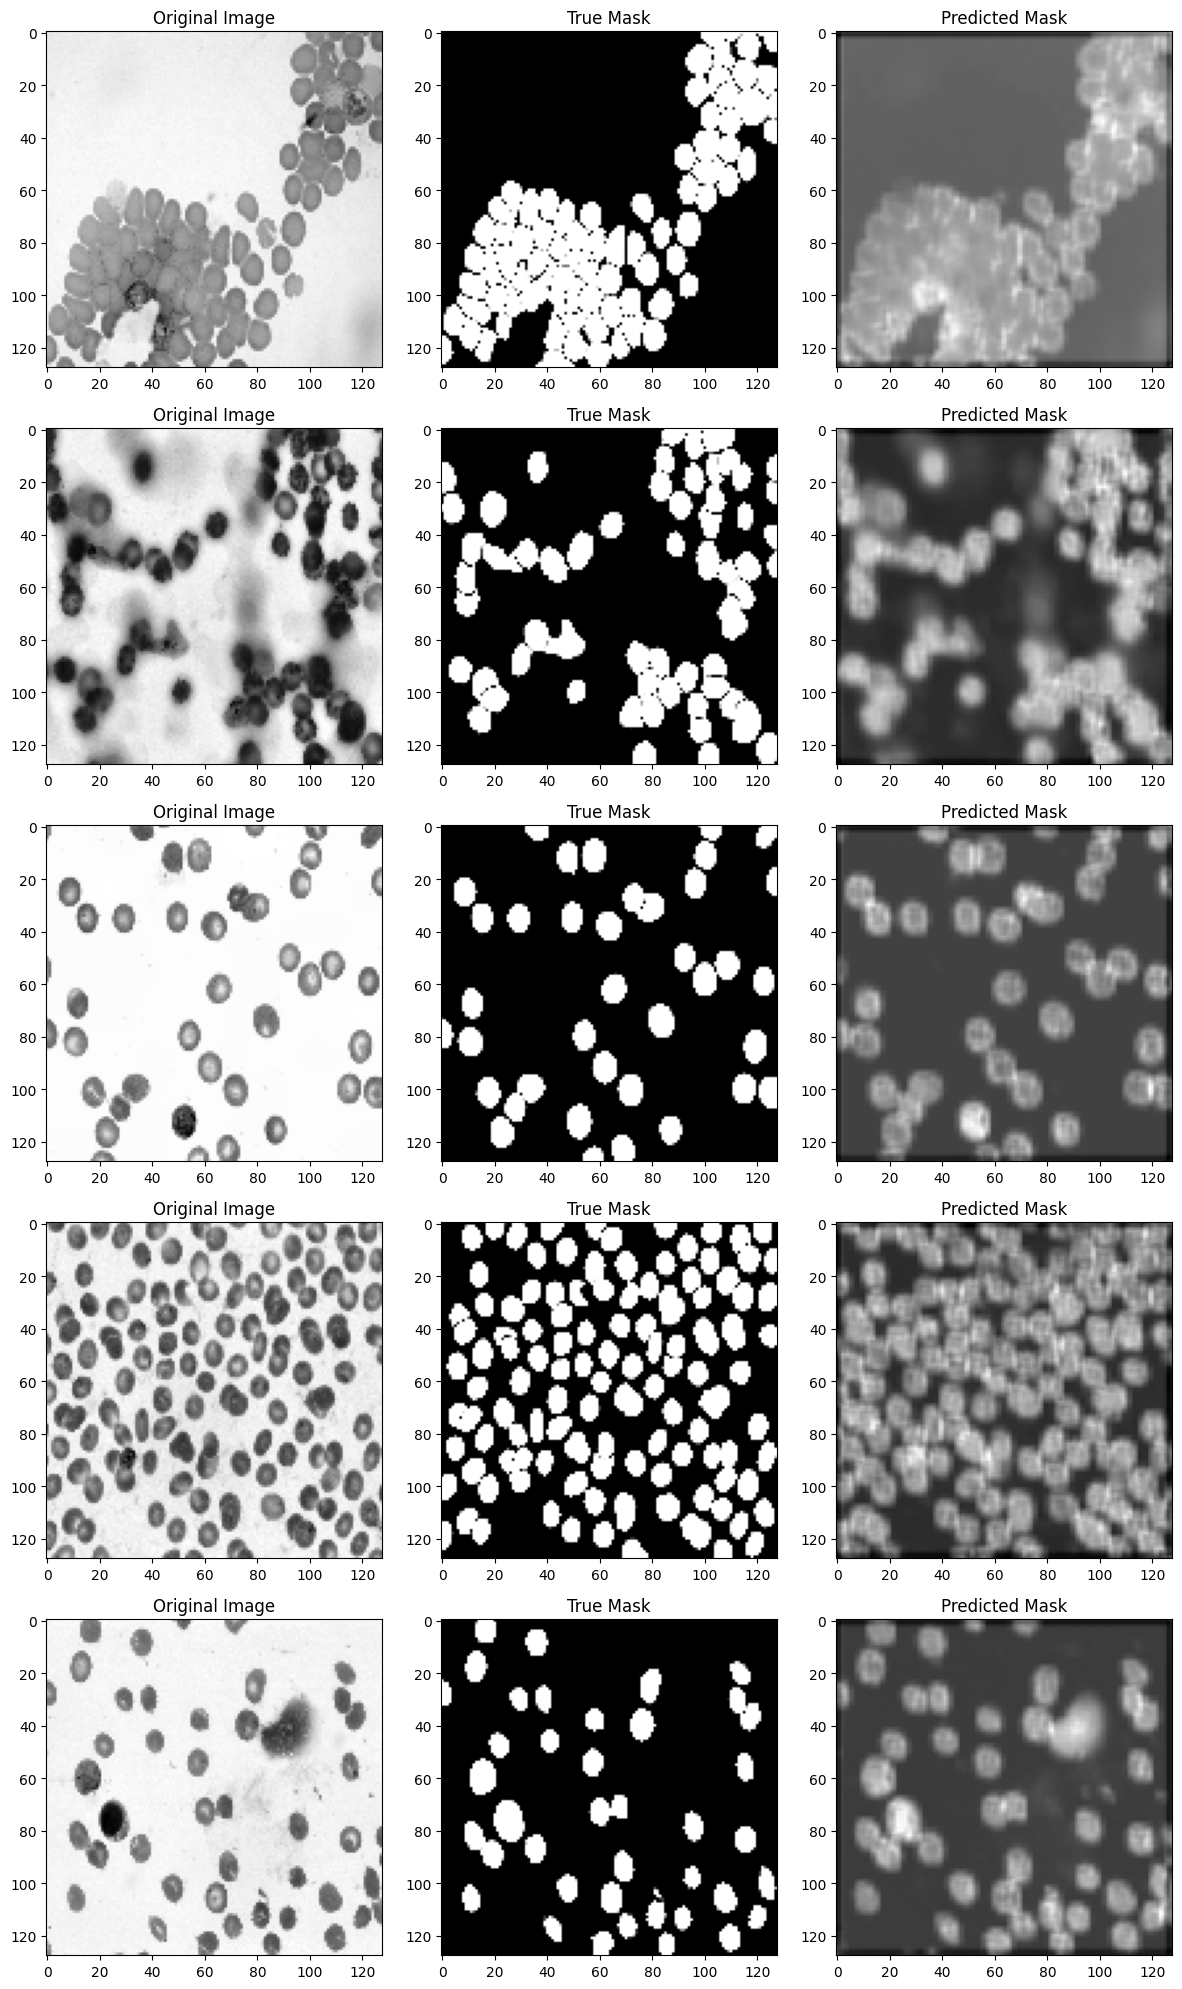

In [15]:
num = 5
fig, axes = plt.subplots(num, 3, figsize=(12, num * 4))
for i in range(num):
    axes[i, 0].imshow(test_images[i].squeeze(), cmap='gray')
    axes[i, 0].set_title("Original Image")
    axes[i, 1].imshow(test_masks[i].squeeze(), cmap='gray')
    axes[i, 1].set_title("True Mask")
    axes[i, 2].imshow(pred_masks[i].squeeze(), cmap='gray')
    axes[i, 2].set_title("Predicted Mask")
plt.tight_layout()
plt.show()

Пример работы модели №1 для аугментированных тестовых и тренировочных данных

In [16]:
train_datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1)
train_generator = train_datagen.flow(train_images, train_masks, batch_size=16)

test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow(test_images, test_masks, batch_size=16)

In [17]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(128, 128, 1)),
    MaxPooling2D((2, 2)),
    UpSampling2D((2, 2)),
    Conv2D(1, (3, 3), activation='sigmoid', padding='same'),
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

c:\Users\kachu\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [18]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(train_generator, epochs=20, validation_data=(test_images, test_masks), callbacks=early_stop)

Epoch 1/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - accuracy: 0.5481 - loss: 0.6635 - val_accuracy: 0.6821 - val_loss: 0.5631
Epoch 2/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - accuracy: 0.7049 - loss: 0.5938 - val_accuracy: 0.6821 - val_loss: 0.5640
Epoch 3/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - accuracy: 0.7051 - loss: 0.5934 - val_accuracy: 0.6821 - val_loss: 0.5571
Epoch 4/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - accuracy: 0.7090 - loss: 0.5886 - val_accuracy: 0.6821 - val_loss: 0.5480
Epoch 5/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - accuracy: 0.6971 - loss: 0.5959 - val_accuracy: 0.6830 - val_loss: 0.5288
Epoch 6/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - accuracy: 0.7000 - loss: 0.5910 - val_accuracy: 0.6842 - val_loss: 0.5204
Epoch 7/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - accuracy: 0.7035 - loss: 0.5890 - val_accuracy: 0.6912 - val_loss: 0.5116
Epoch 8/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - accuracy: 0.7030 - loss: 0.5877 - val_accuracy: 0.6920 - v

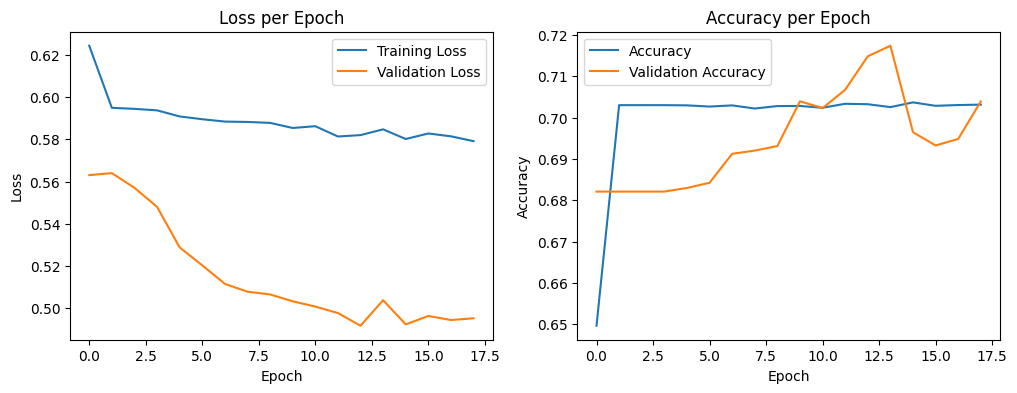

In [19]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch')
plt.legend()

plt.show()

In [20]:
pred_masks = model.predict(test_images)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


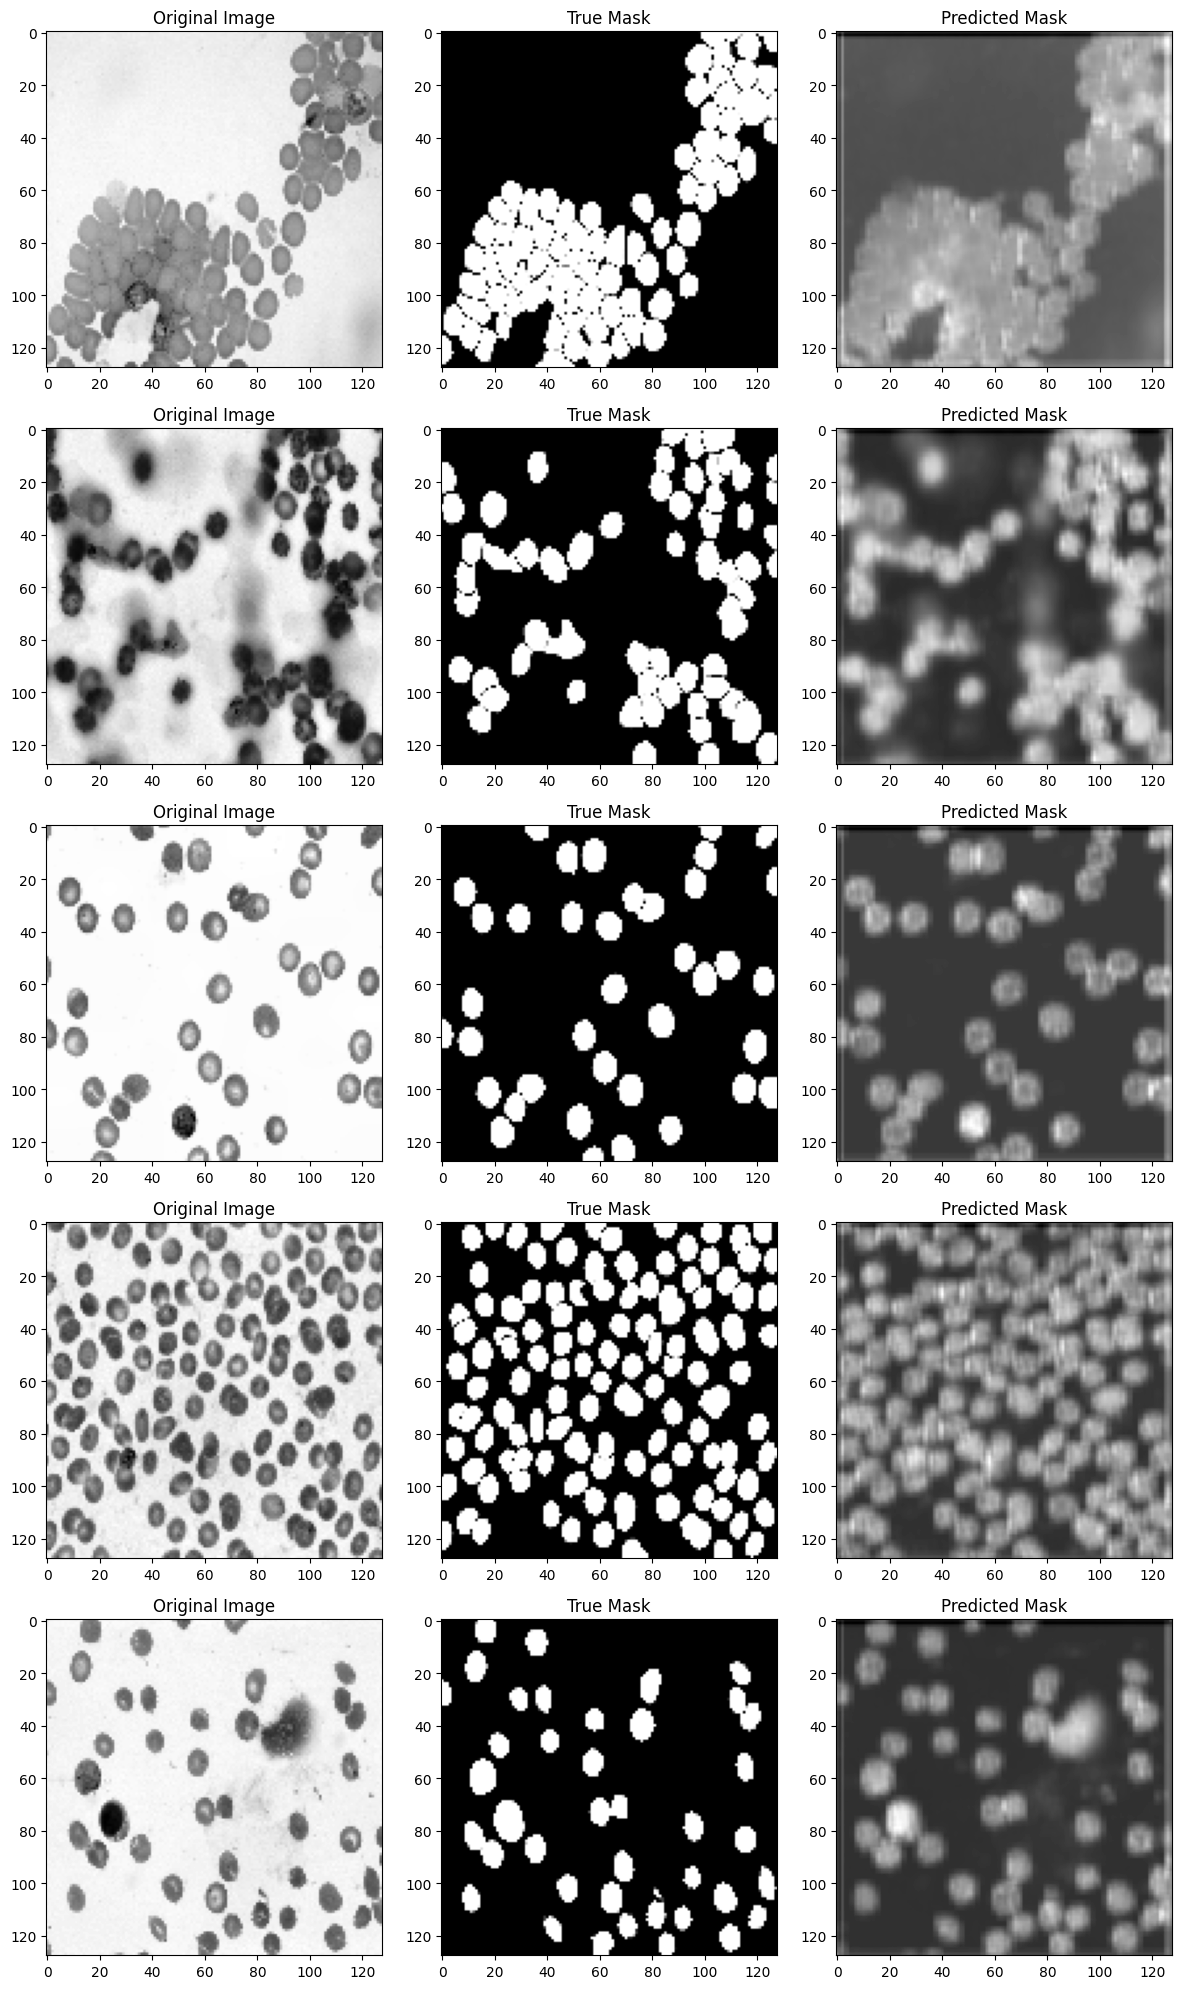

In [21]:
num = 5
fig, axes = plt.subplots(num, 3, figsize=(12, num * 4))
for i in range(num):
    axes[i, 0].imshow(test_images[i].squeeze(), cmap='gray')
    axes[i, 0].set_title("Original Image")
    axes[i, 1].imshow(test_masks[i].squeeze(), cmap='gray')
    axes[i, 1].set_title("True Mask")
    axes[i, 2].imshow(pred_masks[i].squeeze(), cmap='gray')
    axes[i, 2].set_title("Predicted Mask")
plt.tight_layout()
plt.show()

Пример работы модели №1 с изображениями формата 256x256

In [36]:
def images_loader(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, (256, 256))
            img = img / 255.0
            images.append(img)
    return np.array(images).reshape(-1, 256, 256, 1)

In [37]:
train_images = images_loader('data/train/original')
train_masks = images_loader('data/train/mask')
test_images = images_loader('data/test/original')
test_masks = images_loader('data/test/mask')

In [38]:
train_datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1)
train_generator = train_datagen.flow(train_images, train_masks, batch_size=16)

test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow(test_images, test_masks, batch_size=16)

In [39]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(128, 128, 1)),
    MaxPooling2D((2, 2)),
    UpSampling2D((2, 2)),
    Conv2D(1, (3, 3), activation='sigmoid', padding='same'),
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [40]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(train_generator, epochs=20, validation_data=(test_images, test_masks), callbacks=early_stop)

Epoch 1/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 16s 334ms/step - accuracy: 0.6970 - loss: 0.6093 - val_accuracy: 0.6821 - val_loss: 0.5398
Epoch 2/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 14s 311ms/step - accuracy: 0.6992 - loss: 0.5960 - val_accuracy: 0.6821 - val_loss: 0.5295
Epoch 3/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 13s 295ms/step - accuracy: 0.7040 - loss: 0.5907 - val_accuracy: 0.6822 - val_loss: 0.5263
Epoch 4/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 13s 284ms/step - accuracy: 0.7040 - loss: 0.5904 - val_accuracy: 0.6824 - val_loss: 0.5232
Epoch 5/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 13s 287ms/step - accuracy: 0.6936 - loss: 0.5987 - val_accuracy: 0.6834 - val_loss: 0.5165
Epoch 6/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 13s 281ms/step - accuracy: 0.7020 - loss: 0.5890 - val_accuracy: 0.6861 - val_loss: 0.5125
Epoch 7/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 12s 272ms/step - accuracy: 0.7020 - loss: 0.5902 - val_accuracy: 0.6904 - val_loss: 0.5143
Epoch 8/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 13s 297ms/step - accuracy: 0.7035 - loss: 0.5913 - val_accu

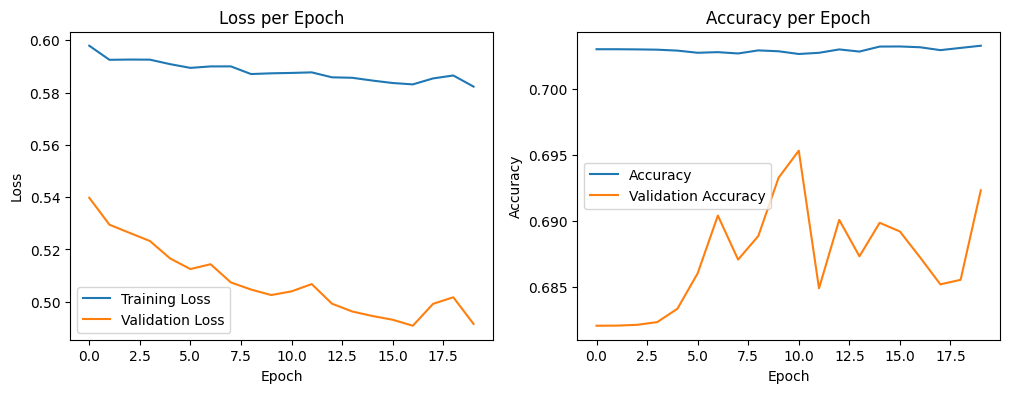

In [41]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch')
plt.legend()

plt.show()

In [42]:
pred_masks = model.predict(test_images)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 210ms/step


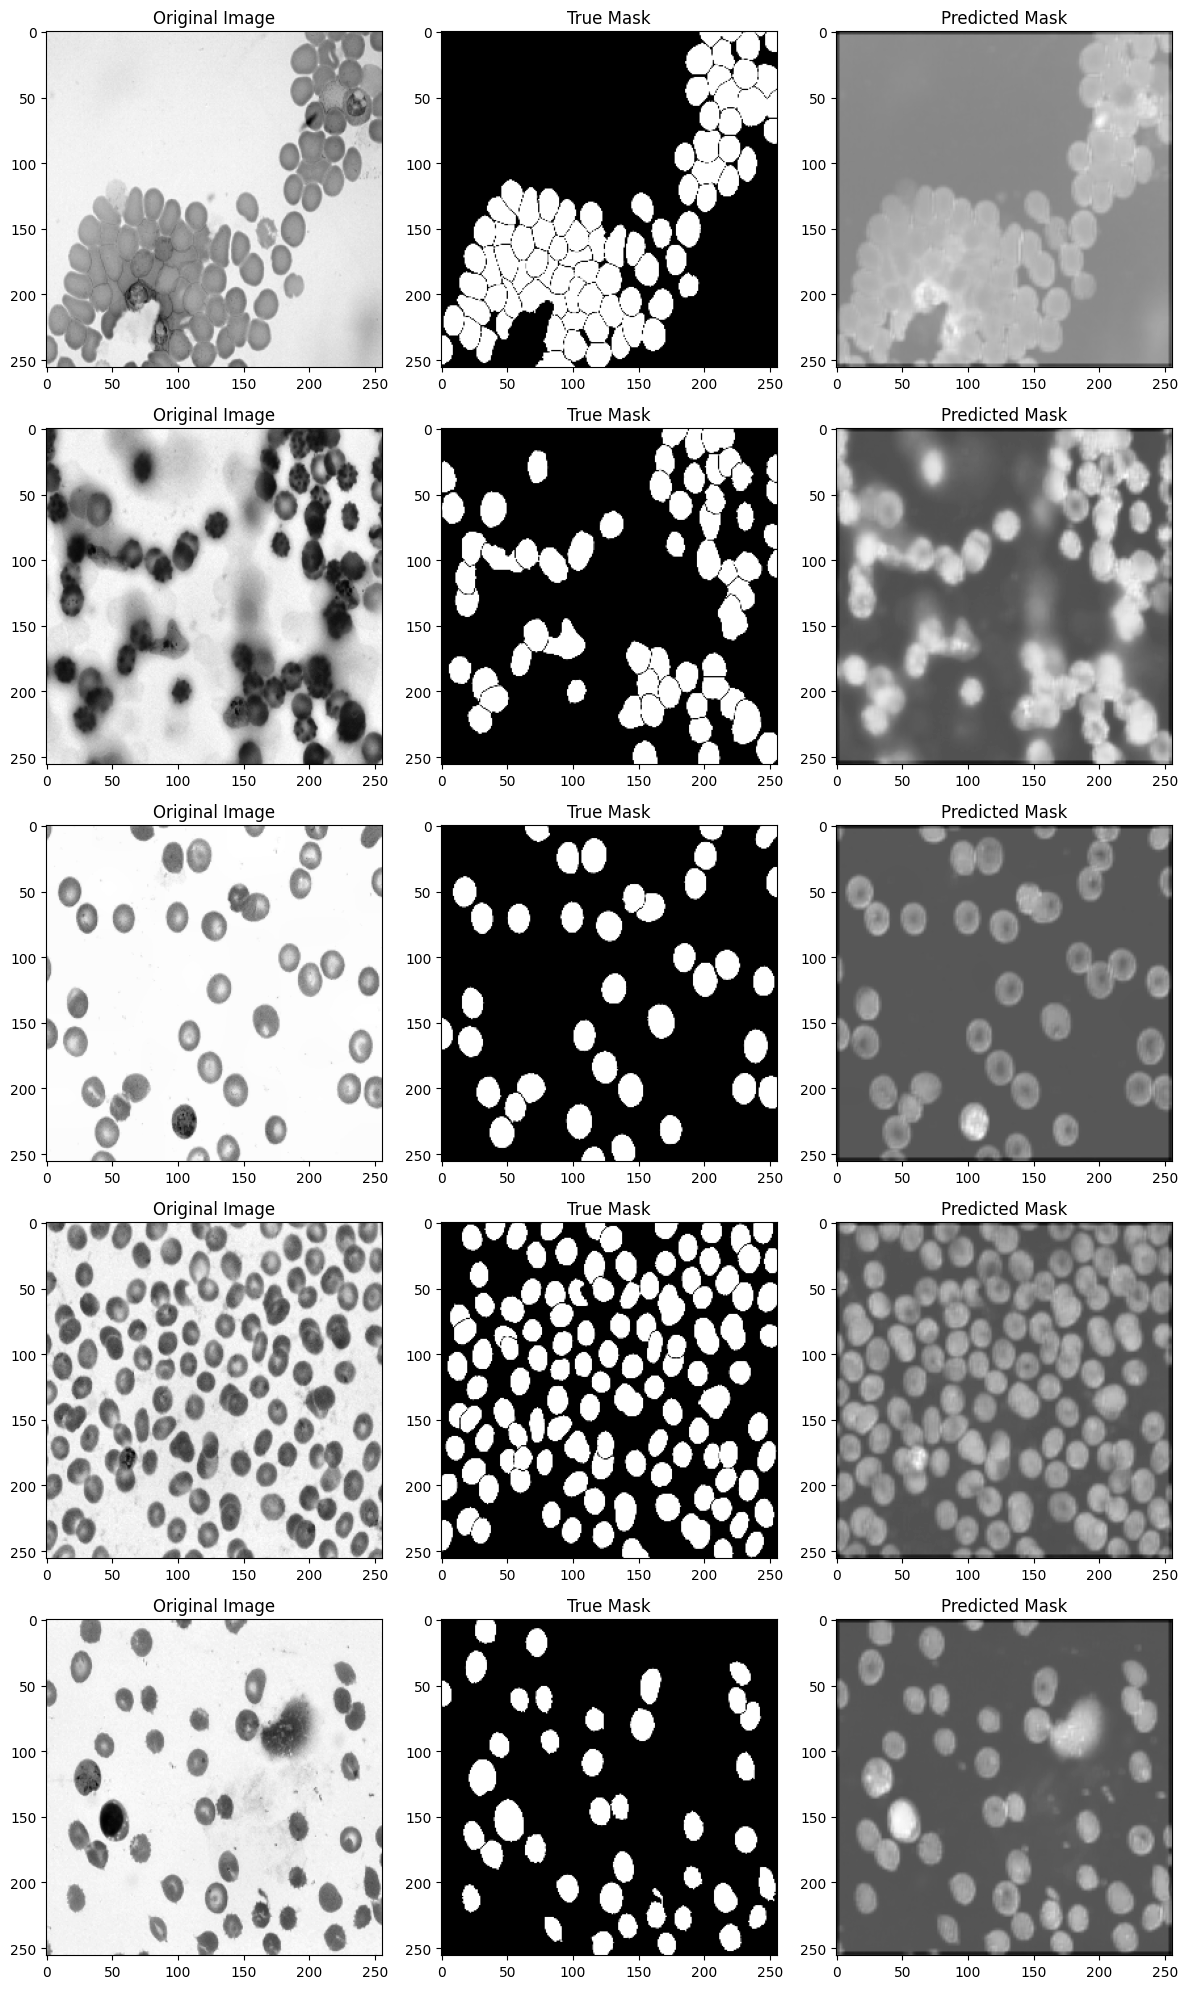

In [43]:
num = 5
fig, axes = plt.subplots(num, 3, figsize=(12, num * 4))
for i in range(num):
    axes[i, 0].imshow(test_images[i].squeeze(), cmap='gray')
    axes[i, 0].set_title("Original Image")
    axes[i, 1].imshow(test_masks[i].squeeze(), cmap='gray')
    axes[i, 1].set_title("True Mask")
    axes[i, 2].imshow(pred_masks[i].squeeze(), cmap='gray')
    axes[i, 2].set_title("Predicted Mask")
plt.tight_layout()
plt.show()

In [44]:
dice_score = dice_coefficient(test_masks, pred_masks)
iou_score = iou_coefficient(test_masks, pred_masks)

print("Dice coefficient:", dice_score.numpy())
print("IoU:", iou_score.numpy())

Dice coefficient: 0.39959562
IoU: 0.24968424


In [45]:
dice_scores = [dice_coefficient(test_masks[i], pred_masks[i]).numpy() for i in range(len(test_images))]
iou_scores = [iou_coefficient(test_masks[i], pred_masks[i]).numpy() for i in range(len(test_images))]

mean_dice_score = np.mean(dice_scores)
mean_iou_score = np.mean(iou_scores)

print("Mean Dice:", mean_dice_score)
print("Mean IoU:", mean_iou_score)

Mean Dice: 0.38528654
Mean IoU: 0.2410607


Пример модели №2 для изображений формата 128х128

In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(128, 128, 1)),
    BatchNormalization(),
    MaxPooling2D(pooal_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    UpSampling2D(size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    UpSampling2D(size=(2, 2)),
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(128, 128, 1)),
    BatchNormalization(),
    Conv2D(1, (1, 1), activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_38 (Conv2D)              │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_16 (UpSampling2D) │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 64, 64, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_17 (UpSampling2D) │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 128, 128, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 128, 128, 1)    │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 186,241 (727.50 KB)

 Trainable params: 185,601 (725.00 KB)

 Non-trainable params: 640 (2.50 KB)

Пример модели №3

In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(128, 128, 1)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    UpSampling2D(size=(2, 2)),
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(128, 128, 1)),
    BatchNormalization(),
    Conv2D(1, (1, 1), activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_7 (UpSampling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 128, 128, 1)    │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,857 (38.50 KB)

 Trainable params: 9,729 (38.00 KB)

 Non-trainable params: 128 (512.00 B)

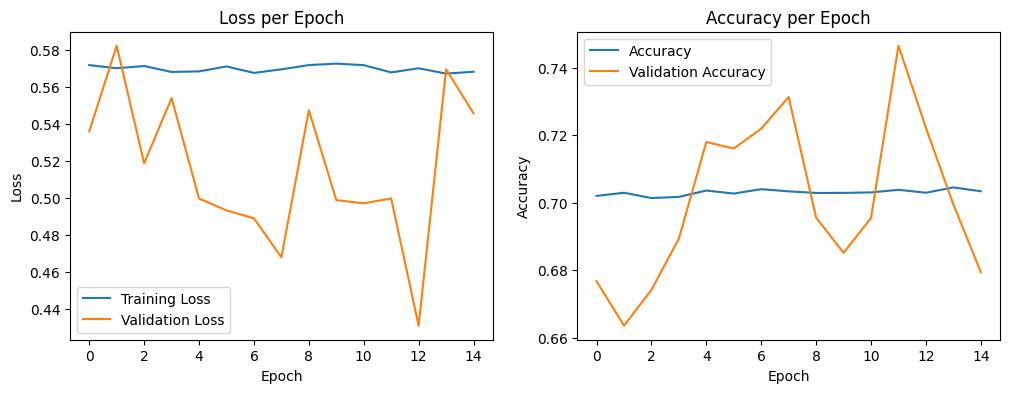

In [35]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch')
plt.legend()

plt.show()

-------------------------------

Дополнение к коду. Вариации кодов

------------------

Подсчеты метрик Dice и IoU

In [ ]:
def dice_coef(y_true, y_pred):
    y_true_f = tf.reshape(tf.dtypes.cast(y_true, tf.float32), [-1])
    y_pred_f = tf.reshape(tf.dtypes.cast(y_pred, tf.float32), [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + 1.) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + 1.)

In [ ]:
def dice_coefficient(y_true, y_pred):
    y_true_f = K.cast(K.flatten(y_true), 'float32')  
    y_pred_f = K.cast(K.flatten(y_pred), 'float32')  
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)

def iou_coefficient(y_true, y_pred):
    y_true_f = K.cast(K.flatten(y_true), 'float32')
    y_pred_f = K.cast(K.flatten(y_pred), 'float32')
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + 1) / (union + 1)

In [ ]:
def dice_coefficient(y_true, y_pred):
    y_true_f = K.flatten(y_true)  
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)

def iou_coefficient(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + 1) / (union + 1)

In [ ]:
def calculate_dice_iou(y_true, y_pred, threshold=0.5):
    y_pred = (y_pred > threshold).astype(int)  
    dice_scores = []
    iou_scores = []
    
    for i in range(y_true.shape[0]):
        intersection = np.sum(y_true[i] * y_pred[i])
        dice_score = (2. * intersection) / (np.sum(y_true[i]) + np.sum(y_pred[i]) + 1e-6)
        dice_scores.append(dice_score)
        
        union = np.sum(y_true[i]) + np.sum(y_pred[i]) - intersection
        iou_score = intersection / (union + 1e-6)
        iou_scores.append(iou_score)
    
    return np.mean(dice_scores), np.mean(iou_scores)

dice_score, iou_score = calculate_dice_iou(test_masks, pred_masks)
print(f"Dice Score: {dice_score:.4f}")
print(f"IoU Score: {iou_score:.4f}")


In [ ]:
def dice_coefficient(y_true, y_pred, threshold=0.5):
    y_pred = (y_pred > threshold).astype(np.float32)
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection) / (np.sum(y_true) + np.sum(y_pred))

def iou_score(y_true, y_pred, threshold=0.5):
    y_pred = (y_pred > threshold).astype(np.float32)
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    return intersection / union


y_pred = model.predict(X_test)
dice_scores = [dice_coefficient(y_true, y_pred) for y_true, y_pred in zip(y_test, y_pred)]
iou_scores = [iou_score(y_true, y_pred) for y_true, y_pred in zip(y_test, y_pred)]

print("Средний Dice:", np.mean(dice_scores))
print("Средний IoU:", np.mean(iou_scores))


In [ ]:
def dice_coefficient(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection) / (np.sum(y_true_f) + np.sum(y_pred_f))

dice_scores = [dice_coefficient(test_masks[i], pred_masks[i]) for i in range(len(test_masks))]
mean_dice_score = np.mean(dice_scores)
print(f"Mean Dice Score: {mean_dice_score}")

Компилирование модели

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[MeanIoU(num_classes=2)])

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coefficient, iou_coefficient])

In [ ]:
from tensorflow.keras.layers import BatchNormalization
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(height, width, channels)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    # ...
])

Обучение модели

Очень несильно влияет

In [ ]:
history = model.fit(train_generator, steps_per_epoch=len(train_images) // 4, epochs=10, 
                    validation_data=test_generator, validation_steps=len(test_images) // 4)

Вывод результата

In [ ]:
def plot_results(images, masks, predictions, num=5):
    plt.figure(figsize=(12, num * 4))
    for i in range(num):
        plt.subplot(num, 3, i * 3 + 1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.title("Original Image")
        
        plt.subplot(num, 3, i * 3 + 2)
        plt.imshow(masks[i].squeeze(), cmap='gray')
        plt.title("True Mask")
        
        plt.subplot(num, 3, i * 3 + 3)
        plt.imshow(predictions[i].squeeze(), cmap='gray')
        plt.title("Predicted Mask")
    plt.show()

plot_results(test_images, test_masks, pred_masks)
